<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 9: Neural Networks (Classification)</h2>
<br>

<a href="#1.-HR-Analytics-Data">HR Analytics Data</a> <br>
<a href="#2.-Feature-Engineering">Feature Engineering</a> <br>
<a href="#3.-Neural-Network">Neural Network</a> <br>
<a href="#4.-Dropout">Dropout</a> <br>
<a href="#5.-Other-Methods">Other Methods</a> <br>
<a href="#6.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
from IPython.display import clear_output

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss, average_precision_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
import lightgbm as lgb

### 1. HR Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data available from [Kaggle Datasets](https://www.kaggle.com/datasets). Our objective is to predict To predict which employees will leave the company.

In [4]:
data = pd.read_csv('Data/HR.csv')
data = data.rename(columns = {'sales' : 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
print(data.shape)

(14999, 10)


In [6]:
response='left'
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.5, random_state=5)

y_train = data.loc[index_train, response].to_numpy()
y_test = data.loc[index_test, response].to_numpy()

### 2. Feature Engineering

Before training the models, we need to convert the categorical variables into binary variables. 

In [7]:
for label in ['role', 'salary']:
    dummies = pd.get_dummies(data[label], drop_first=True)
    data = data.join(dummies)
    data = data.drop(label, axis= 1)
    
predictors = list(data.columns)
predictors.remove(response)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

X_train = data.loc[index_train, predictors].to_numpy()
X_test = data.loc[index_test, predictors].to_numpy()

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train.shape

(7499, 18)

### 3. Neural Network

**3.1 Specifying the model** 

We specify a multilayer perceptron with two hidden layers.

In [9]:
from keras.models import Sequential
from keras.layers import Dense

mlp = Sequential()
mlp.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
clear_output()
mlp

**3.2 Creating a Validation Set** 

In [10]:
n_val = int(np.floor(0.2*len(y_train)))

X_train_partial = X_train[:-n_val,:]
y_train_partial = y_train[:-n_val]
X_val =  X_train[-n_val:,:]
y_val =  y_train[-n_val:]

**3.3 Training the Neural Network** 

In [11]:
fitted = mlp.fit(X_train_partial, y_train_partial, epochs=80, validation_data=(X_val, y_val), verbose=0)

Instructions for updating:
Use tf.cast instead.


In [12]:
history = fitted.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

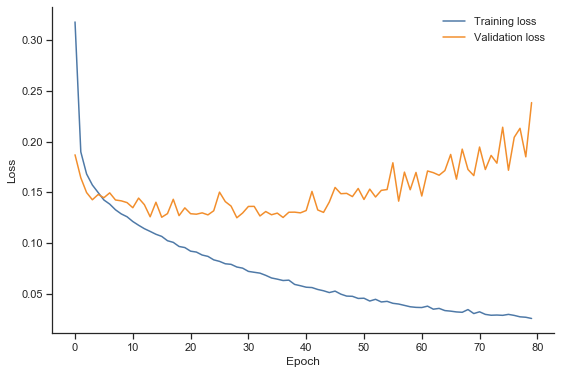

In [13]:
fig, ax= plt.subplots()
ax.plot(history['loss'], label='Training loss')
ax.plot(history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
sns.despine()
plt.show()

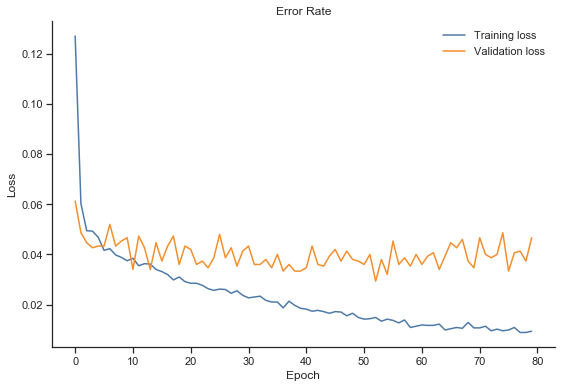

In [14]:
fig, ax= plt.subplots()
ax.plot(1-np.array(history['acc']), label='Training loss')
ax.plot(1-np.array(history['val_acc']), label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Error Rate')
ax.legend(frameon=False)
sns.despine()
plt.show()

In [15]:
mlp = Sequential()
mlp.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=20)

Epoch 1/20
7499/7499 [==============================] - 1s 82us/step - loss: 0.2981 - acc: 0.8820
Epoch 2/20
7499/7499 [==============================] - 0s 41us/step - loss: 0.1809 - acc: 0.9459
Epoch 3/20
7499/7499 [==============================] - 0s 39us/step - loss: 0.1629 - acc: 0.9529
Epoch 4/20
7499/7499 [==============================] - 0s 41us/step - loss: 0.1530 - acc: 0.9545
Epoch 5/20
7499/7499 [==============================] - 0s 39us/step - loss: 0.1457 - acc: 0.9563
Epoch 6/20
7499/7499 [==============================] - 0s 43us/step - loss: 0.1399 - acc: 0.9587
Epoch 7/20
7499/7499 [==============================] - 0s 39us/step - loss: 0.1346 - acc: 0.9601
Epoch 8/20
7499/7499 [==============================] - 0s 38us/step - loss: 0.1280 - acc: 0.9621
Epoch 9/20
7499/7499 [==============================] - 0s 39us/step - loss: 0.1251 - acc: 0.9636
Epoch 10/20
7499/7499 [==============================] - 0s 40us/step - loss: 0.1193 - acc: 0.9641
Epoch 11/20
7499/74

### Dropout

In [16]:
from keras.layers import Dropout

mlp_dropout = Sequential()
mlp_dropout.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
mlp_dropout.add(Dropout(0.5))
mlp_dropout.add(Dense(64, activation='relu'))
mlp_dropout.add(Dense(1, activation='sigmoid'))
mlp_dropout.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
mlp_dropout.fit(X_train, y_train, epochs=200, verbose=0)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 5. Other Methods

**5.1 Logistic Regression**

In [17]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=np.inf, solver='lbfgs')
logit.fit(X_train, y_train)

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**5.2 Random Forest**

In [18]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1]),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 32, scoring='neg_log_loss', n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 5} 

Wall time: 26.7 s


In [19]:
rf.n_estimators = 1000
rf.random_state = 1
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

**5.3 Gradient Boosting**

In [20]:
from xgboost import XGBClassifier
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [21]:
%%time

model = XGBClassifier()

space = {
    'reg_lambda':  (1e-15, 1000, 'log-uniform'),
    'gamma':  (1e-15, 1000, 'log-uniform'),
    'learning_rate': Real(0.005, 0.15),
    'n_estimators' : Integer(100, 2000),
    'max_depth' : Integer(2, 10),
    'subsample' : Real(0.5, 1.0),
}

np.random.seed(87)
xgb_search =  BayesSearchCV(model, space, cv = 5,  n_iter=32, scoring = 'neg_log_loss', n_jobs=4)
xgb_search.fit(X_train, y_train)

xgb = xgb_search.best_estimator_

print('Best parameters found by Bayesian estimation:', xgb_search.best_params_, '\n')

Best parameters found by Bayesian estimation: {'gamma': 3.589181775873712e-06, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 1551, 'reg_lambda': 1.9870009752320832e-12, 'subsample': 1.0} 

Wall time: 10min 46s


### 6. Model Evaluation


In [22]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision', 'Average Precision']
rows=['Logistic regression', 'Random Forest', 'XGBoost', 'Neural Net', 'Neural Net (dropout)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, rf, xgb, mlp, mlp_dropout]

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test)
    if (method == mlp) | (method == mlp_dropout):
        y_prob = y_pred
        y_pred = (y_pred>0.5).astype(int)
    else:
        y_prob = method.predict_proba(X_test)[:,1]
        


    confusion  = confusion_matrix(y_test, y_pred)
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)
    results.iloc[i,3] = roc_auc_score(y_test, y_prob)
    results.iloc[i,5]=  average_precision_score(y_test, y_prob)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision,Average Precision
Logistic regression,0.211,0.342,0.929,0.827,0.601,0.533
Random Forest,0.024,0.911,0.996,0.992,0.985,0.984
XGBoost,0.017,0.943,0.995,0.994,0.984,0.987
Neural Net,0.038,0.927,0.973,0.983,0.915,0.954
Neural Net (dropout),0.031,0.901,0.990,0.978,0.967,0.960


### Additional Code

The two cells below format the notebook for display online. Please omit them from your work.

In [23]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [24]:
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')